# 串起来：让机器人可以简单地玩游戏


In [1]:
from CyClient import *
import time
import numpy as np
from matchUtil import *
from Cut import *
import matplotlib.pyplot as plt
from findTemplate import *
cli = Client()
cli.sayHello()

received:     Hello From Server 


In [2]:
cli.takAction(4,0,0)
time.sleep(0.5)
cli.takAction(3,0,0)

received:     M         4         0         0
received:     M         3         0         0


## test

received: 
600 800 3
30000


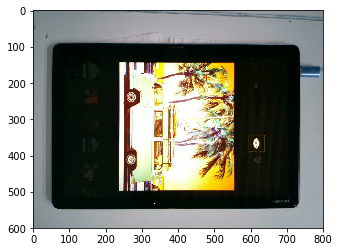

0.0


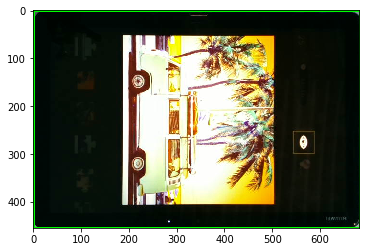

In [3]:
test = cli.getPic()
plt.imshow(test)
plt.show()
cut = get_Contour(test)
plt.imshow(cut)
plt.show()

In [17]:
from matchUtil import *

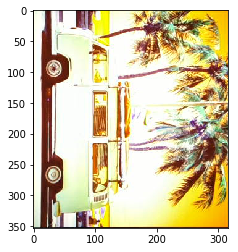

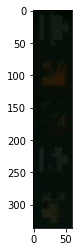

[36, 6]


In [4]:
sor = cutout_source(cut,cut)
plt.imshow(sor)
plt.show()  
#s_x = int(sor.shape[0]/5)
#s_y = int(sor.shape[1]/5)
    
temp_area = cutout_template_area(cut,cut)
plt.imshow(temp_area)
plt.show()
temp_pos = []
temp = cutout_template(cut,cut,temp_pos)
#temp_pos
plt.imshow(temp)
print(temp_pos)

In [70]:
img = ply.getOneShot()
plt.imsave("fullEmpty.png",img)

received: 
600 800 3
30000
-0.0


In [18]:
template = cut
print(temp_pos)
imgshape = template.shape
print(imgshape)
#PHONESIZE = (155,235)
diviceShape = (155,235)
temp_pos_1 = (temp_pos[0]+20 + template.shape[1]*0.114 , temp_pos[1] +25+ template.shape[0]*0.111)
print(temp_pos_1)
x,y =temp_pos_1
#1,0,0,1
x =  (1-x/imgshape[1]) * diviceShape[1] # because x is converted
y =  y/imgshape[0] * diviceShape[0]
print(x+10,y+10)

[6, 10]
(505, 735, 3)
(109.79, 91.055)
209.89707482993197 37.94757425742574


In [58]:
x,y = temp_pos_1
(1-x/imgshape[1])*

0.8352455418381344

In [14]:
cli.takAction(1,int(x),int(y))

received:     M         1         1 2 5         1 3 7


In [52]:
cli.takAction(1,110,210)

received:     M         1         1 1 0         2 1 0


received: 
600 800 3
30000
-1.432096242904663


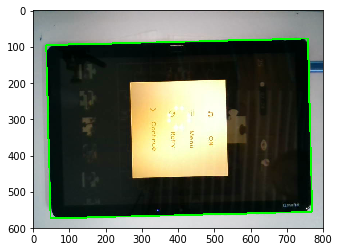

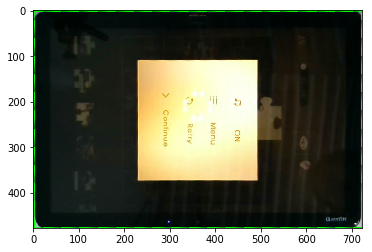

In [35]:
test = cli.getPic()
#plt.imshow(test)
#cv2.imwrite
cut = get_Contour(test)
plt.imshow(test)
plt.show()
#cv2.imwrite("cut_pad.png",cut)
plt.imshow(cut)
plt.show()

# calibration

In [38]:
cli.takAction(1,10,10)

received:     M         1         1 0         1 0


In [39]:
cli.takAction(1,170,10)

received:     M         1         1 7 0         1 0


In [40]:
cli.takAction(1,10,255)

received:     M         1         1 0         2 5 5


In [22]:
cli.getPos() # left upper corner  it is 85, 10, 0, right bottom corner is 15 -135 
'''
base
base = 10 10
pad:left upper corner is 165,10 ,right bottom corner is 15,245,
'''


received: 
(10.0, 245.0, 0)


'\nbase\nbase = 10 10\npad:left upper corner is 165,10 ,right bottom corner is 15,245,\n'

In [20]:
# PHONESIZE = (150,235)
PHONESIZE = (160,245)


In [62]:
class Player:
    def __init__(self,cli):
        self.cli = cli
        self.basePoint = np.array([0,0])
        self.sourceimg = None # the image of the jagsaw to recover
        self.emptyimg = None # the image of the empty target area 
    def setBase(self):
        # move to where 0,0 point should be in the figure
        curr = self.cli.getPos()
        print("current position: ", curr[:2])
        self.basePoint = np.array(curr[:2])
        
    def moveto(self,x,y):
        x += self.basePoint[0]
        y += self.basePoint[1]
        x,y = int(x),int(y)
        cx,cy,_  =self.cli.getPos()
        self.cli.takAction(1,x,y)
         # getPos can not get the current pos, but the target pos
        # the time is 2.76s to move from -10,-10 to 100,100
        speed = 56
        dist = ((x-cx)**2+(y-cy)**2)**(1/2)
        waittime = dist/speed + 0.5
        time.sleep(waittime)
        
        
    def movetoImg(self,x,y,imgshape,diviceShape = PHONESIZE):
        # imgshape is (y_shape, x_shape)
        '''
        x =  (1-x/imgshape[1]) * diviceShape[0] # because x is converted
        y =  y/imgshape[0] * diviceShape[1]
        '''
        x =  (1-x/imgshape[1]) * diviceShape[1] # because x is converted
        y =  y/imgshape[0] * diviceShape[0]
        x,y = y,x
        self.moveto(x,y)
    
    def retreat(self):
        #self.moveto(-10,-10)
        cx,cy,_  =self.cli.getPos()
        if(cy - self.basePoint[0] < 137):
            self.moveto(-10,-10)
        else:
            self.moveto(-10,255)

#         self.cli.takAction(3,0,0)
    
    def clickAtImg(self, x, y,imgshape,diviceShape = PHONESIZE):
        print(imgshape,diviceShape)
        self.movetoImg(x, y,imgshape,diviceShape)
#         time.sleep(2)
#         self.cli.takAction(2,0,0)
        self.cli.takAction(4,0,0)
        time.sleep(0.5)
        self.cli.takAction(3,0,0)
        self.retreat()
    
    def dragAtImg(self, x0,y0,x1,y1,imgshape,diviceShape = PHONESIZE,roundAbout = None):
        self.movetoImg(x0,y0,imgshape,diviceShape)
        self.cli.takAction(4,0,0)
#         time.sleep(0.2)
        if(roundAbout is not None):
            x2,y2 = roundAbout
            self.movetoImg(x2,y2,imgshape,diviceShape)
        self.movetoImg(x1,y1,imgshape,diviceShape)
        self.cli.takAction(3,0,0)
    
    def tryOneDrag(self,x0,y0,x1,y1,imgshape,diviceShape = PHONESIZE, shot = False, back = True, roundAbout = None):
        # drag the piece to the position and then drag it back
        # if it is the correct piece it will stay there
#         targetShape = 
        # roundAbout is the point first drag to
        sx = int(imgshape[1]*(0.735-0.273)/10) # the shift amount
        sy = int(imgshape[0]*(0.895-0.120)/10)
#         print("shot:",shot,"back",back)
        self.dragAtImg(x0,y0,x1-sx*1.25,y1+sy,imgshape,PHONESIZE,roundAbout)
        if(shot):
            self.retreat()
#             time.sleep(0.5)
            img = self.getOneShot()
            if(not back):
                return img
#         else:
#             time.sleep(2)
        #self.dragAtImg(x1,y1+30,x0,y0-30,imgshape,diviceShape = PHONESIZE)
        self.dragAtImg(x1+sx,y1+sy,x0-2*sx,y0,imgshape,diviceShape = PHONESIZE) # Note the x,y = y,x in movetoImg
        self.retreat()
        if(shot):
            return img
        
    def getOneShot(self):
        img = self.cli.getPic()
        img = get_Contour(img)
        return img
    
    def initGame(self):
        # The phone should be before the game start
        self.retreat()
        img = self.getOneShot()
        #source ?
        self.sourceimg = img
        y,x = img.shape[:2]
        #x,y = x*0.502,y*0.237
        y,x = x*0.4,y*0.84
        self.clickAtImg(x,y,img.shape[:2])
        img = self.getOneShot()
        self.emptyimg = cutout_target(img)
        plt.imshow(self.sourceimg)
        plt.show()
        plt.imshow(self.emptyimg)
        plt.show()
    def DragToCorner(self,sor_shape,img_shape,tempPos = None,ex = 0, ey = 0):
        img = self.getOneShot()
        target = cutout_target(img)
        if(tempPos is None):
            tempPos = []
            _ = cutout_template(None,img.copy(),tempPos)
            x0,y0 = (tempPos[0] + img.shape[1]*0.114 , tempPos[1] + img.shape[0]*0.111)
        else:
            x0,y0 = tempPos
        # shift from the corner to the middle of the template
        x0,y0 = x0+10+20, y0+30
        x = int(ex*sor_shape[1]/5) + int(img_shape[1]*0.273)
        y = int(ey*sor_shape[0]/5) + int(img_shape[0]*0.120)
        
        return self.tryOneDrag(x0,y0,x,y,img.shape[:2],shot = True,back = False,roundAbout =( (x+20,y0) if x==0 else None ))
    
    def dragToGrid(self,x0,y0,x1,y1,sor_shape,img_shape,shot,back = True):
        """
        x,y is the cordinate of the source area 0...4
        """
        x0 = int(x0*sor_shape[1]/5 + img_shape[1]*0.273 + sor_shape[1]/10)
        y0 = int(y0*sor_shape[0]/5 + img_shape[0]*0.120 + sor_shape[0]/10)
        x1 = int(x1*sor_shape[1]/5) + int(img_shape[1]*0.273)
        y1 = int(y1*sor_shape[0]/5) + int(img_shape[0]*0.120)
        # print("self.tryOneDrag",x0,y0,x1,y1,img_shape[:2],shot,back)
        return self.tryOneDrag(x0,y0,x1,y1,img_shape[:2],shot = shot,back = back)

    def playOneStep(self):
        img = self.getOneShot() # whole screen before move
        target = cutout_target(img.copy())

        (x0,y0), scores = old_matching(self.sourceimg.copy(),img.copy(),mode = "match",debug = False)
        scores += np.random.random((5,5))/5
        print("Template: ",x0,y0,"img shape: ", img.shape[:2])
        possible = findEmpty(self.emptyimg,target,mode = "debug")
        ey = np.argmax(scores)//5 
        ex = np.argmax(scores)%5
        while(not possible[ey][ex]):
            scores[ey][ex] = -1
            ey = np.argmax(scores)//5 
            ex = np.argmax(scores)%5
        print("###EX,EY####",ex,ey)
        moved_template = self.DragToCorner(target.shape[:2],img.shape[:2],(x0,y0),ex,ey) # screen after the template is moved to corner
    #     global tmpcount
    #     cv2.imwrite("tmpMovedTemplate%d.png"%tmpcount,moved_template)
    #     cv2.imwrite("tmpSourceImg%d.png"%tmpcount,img)
    #     tmpcount += 1    
        template = find_template(moved_template,img,ex,ey)
        plt.imshow(template)
        plt.show()
        source = cutout_target(self.sourceimg)
        scores = matching(source,template)
        initial_num = possible.sum()
        print("possible:", possible)
        print("scores:",scores)
    #     ex,ey = 0,0 # the point to check the correctness
        scores[ey][ex] = -1
        triedCount = 0
        while(possible.sum()>0):
            y = np.argmax(scores)//5 # x => i 
            x = np.argmax(scores)%5
            print("DRAG TO: ",x,y)
            scores[y][x]=-1
            if(not possible[y][x] ): # we don't have to move to 0,0, we just check it in the next round
                continue
            possible[y][x] = False

            timg = self.dragToGrid(ex,ey,x,y,target.shape[:2],img.shape[:2],shot=True, back = False)
            timg = cutout_target(timg)
    #         print("Tries To Drag:",x0,y0,x,y)

            triedCount += 1

            empty = findEmpty(self.emptyimg,timg,mode = "release")
            print("TRIED:", triedCount )
            if(not empty[ey][ex] or empty[y][x]):
                break
            ex,ey = x,y

        
ply = Player(cli)

In [63]:
cli.takAction(1,10,10)

received:     M         1         1 0         1 0


In [64]:
ply.setBase()
# ply.moveto(-10,-10)

received: 
(10.0, 10.0, 0)
current position:  (10.0, 10.0)


In [65]:
ply.retreat()

received: 
(10.0, 10.0, 0)
received: 
(10.0, 10.0, 0)
received:     M         1         0         0


received: 
(0.0, 0.0, 0)
received: 
(0.0, 0.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-0.1439589411020279
(457, 686) (160, 245)
received: 
(0.0, 0.0, 0)
received:     M         1         1 0 6         1 1 7
received:     M         4         0         0
received:     M         3         0         0
received: 
(106.0, 117.0, 0)
received: 
(106.0, 117.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-0.23290841281414032


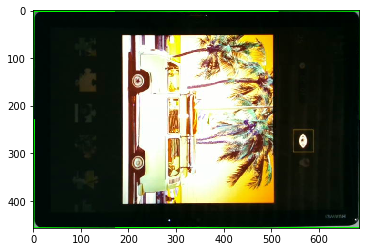

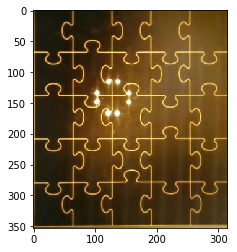

In [67]:
ply.initGame()

received: 
600 800 3
30000
-0.1267603635787964
Template:  89.20400000000001 54.727000000000004 img shape:  (457, 686)


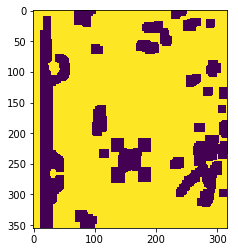

[[196.16700201 196.22401073 221.3648558  161.39168343 222.61904762]
 [120.23138833 255.         255.         250.72434608 176.84104628]
 [174.04761905 194.17169685 243.65526492 254.14486922 194.51374916]
 [131.63313213 243.02816901  87.62240107 218.51441985  68.12541918]
 [148.6787391  207.73977197 255.         234.8759222  195.19785379]]
###EX,EY#### 4 3
received: 
600 800 3
30000
-0.1284656673669815
received: 
(0.0, 265.0, 0)
received:     M         1         3 9         2 1 2
received:     M         4         0         0
received: 
(39.0, 212.0, 1)
received:     M         1         1 1 5         1 1 1
received:     M         3         0         0
received: 
(115.0, 111.0, 0)
received: 
(115.0, 111.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-0.22207558155059814


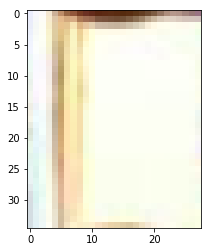

possible: [[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False  True False  True]
 [False False False False False]]
scores: [[0.55825609 0.55895317 0.55895317 0.38729814 0.24542372]
 [0.60316849 0.54280978 0.6092267  0.5765059  0.3674747 ]
 [0.42071342 0.29460678 0.43421364 0.31467274 0.21951605]
 [0.44083819 0.43683177 0.79635209 0.55248398 0.29920971]
 [0.45854571 0.52483577 0.52483577 0.35064209 0.25301743]]
DRAG TO:  2 3
received: 
(0.0, 0.0, 0)
received:     M         1         1 1 6         8 6
received:     M         4         0         0
received: 
(116.0, 86.0, 1)
received:     M         1         1 1 5         1 5 7
received:     M         3         0         0
received: 
(115.0, 157.0, 0)
received: 
(115.0, 157.0, 0)
received:     M         1         0         2 6 5
received: 
600 800 3
30000
-0.13232257962226868
[[198.27632461 183.28303152  32.20992622  74.73843058  48.9704896 ]
 [255.

In [69]:
for i in range(25):
    ply.playOneStep()

In [35]:
#ply.tryOneDrag(100,40, 300,100,ply.sourceimg.shape[:2])
ply.tryOneDrag(430,440, 420,200,ply.sourceimg.shape[:2])
#cli.takAction(1,45,10)

AttributeError: 'NoneType' object has no attribute 'shape'

In [66]:
img = ply.getOneShot() # whole screen before move
target = cutout_target(img)
a= ply.DragToCorner(target.shape[:2],img.shape[:2],None,4,4)

received: 
600 800 3
30000
-0.2459031045436859
received: 
600 800 3
30000
-0.2459031045436859
received: 
(0.0, 0.0, 0)
received:     M         1         1 0 8         2 1 3
received:     M         4         0         0
received: 
(108.0, 213.0, 1)
received:     M         1         1 4 0         1 1 1
received:     M         3         0         0
received: 
(140.0, 111.0, 0)
received: 
(140.0, 111.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-0.23529961705207825


In [ ]:
ply.sourceimg.shape[:2]

received:     M         1         3 5         0


In [47]:
from matchUtil import *

In [45]:
# ply.movetoImg(82.878+20,203.391+30,(481,727)) # the +20 and +30 here is to assemble the effect in tryOneDrag
ply.movetoImg(150,85,(481,727)) # the +20 and +30 here is to assemble the effect in tryOneDrag

received: 
(35.0, 196.0, 1)
received:     M         1         3 6         1 9 6


In [21]:
cli.takAction(3,0,0)

received:     M         3         0         0


In [37]:
ply.retreat()

received: 
(10.0, 255.0, 0)
received:     M         1         0         0


In [16]:
def DragToCorner(ply,sor_shape,img_shape,tempPos = None,ex = 0, ey = 0):
    img = ply.getOneShot()
    target = cutout_target(img)
    if(tempPos is None):
        tempPos = []
        _ = cutout_template(None,img.copy(),tempPos)
        x0,y0 = (tempPos[0] + img.shape[1]*0.114 , tempPos[1] + img.shape[0]*0.111)
    else:
        x0,y0 = tempPos
#     (x0,y0), _= matching(ply.sourceimg,img.copy(),mode = "match",debug = True)
    # shift from the corner to the middle of the template
    x0,y0 = x0+10+20, y0+30
    
#     x,y = int(img.shape[1]*0.273), int(img.shape[0]*0.120)
    x = int(ex*sor_shape[1]/5) + int(img_shape[1]*0.273)
    y = int(ey*sor_shape[0]/5) + int(img_shape[0]*0.120)
    print("###########################")
    print("DRAG TO CORNER tryOneDrag:",x0,y0,x,y,img.shape[:2])
    return ply.tryOneDrag(x0,y0,x,y,img.shape[:2],shot = True,back = False,roundAbout = (x+20,y0))
# img = DragToCorner(ply)

In [42]:
# ply.movetoImg(180+20,57+40, [479,730])
# cli.takAction(4,0,0)
ply.movetoImg(199,57, [479,730])

# ply.retreat()

received: 
(41.0, 204.0, 1)
received:     M         1         4 3         2 0 4


In [17]:
def dragToGrid(ply,x0,y0,x1,y1,sor_shape,img_shape,shot,back = True):
    """
    x,y is the cordinate of the source area 0...4
    """
    x0 = int(x0*sor_shape[1]/5 + img_shape[1]*0.273 + sor_shape[1]/10)
    y0 = int(y0*sor_shape[0]/5 + img_shape[0]*0.120 + sor_shape[0]/10)
    x1 = int(x1*sor_shape[1]/5) + int(img_shape[1]*0.273)
    y1 = int(y1*sor_shape[0]/5) + int(img_shape[0]*0.120)
    # to get to the middle of the template
#     x0,y0 = x0 +34, y0+37 # sor_shape[1]/10
    
    print("ply.tryOneDrag",x0,y0,x1,y1,img_shape[:2],shot,back)
    return ply.tryOneDrag(x0,y0,x1,y1,img_shape[:2],shot = shot,back = back)

# img = ply.getOneShot()
# sor = cutout_target(img)
# plt.imshow(sor)
# plt.show()
# dragToGrid(ply,2,2,0,0,sor.shape[:2],img.shape[:2],False)
# dragToGrid(ply,0,0,2,4,sor.shape[:2],img.shape[:2],False)

In [117]:
sor.shape

(373, 337, 3)

In [119]:
ply.movetoImg(233-34-35,94-37+37, [481,729])

received: 
(41.0, 206.0, 1)
received:     M         1         4 1         1 9 9


In [14]:
ply.retreat()

received: 
(115.0, 201.0, 0)
received:     M         1         0         0


In [46]:
cli.takAction(3,0,0)

received:     M         3         0         0


received: 
600 800 3
30000
-4.618321895599365


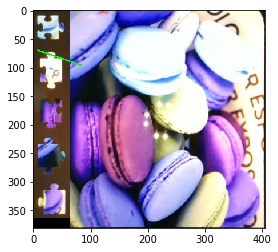

Template:  92.24600000000001 124.501 img shape:  (491, 739)


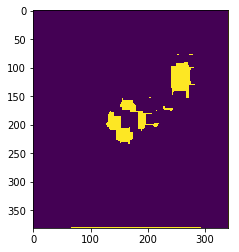

[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         78.45394737  6.51315789]
 [ 0.          8.63486842 95.03289474  7.45065789  0.        ]
 [ 0.          0.          3.40460526  0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
###EX,EY#### 0 1
received: 
600 800 3
30000
-4.642602443695068
###########################
DRAG TO CORNER tryOneDrag: 122.24600000000001 154.501 201 134 (490, 739)
received: 
(0.0, 0.0, 0)
received:     M         1         6 0         2 1 4
received:     M         4         0         0
received: 
(60.0, 214.0, 1)
received:     M         1         6 0         1 8 1
received: 
(60.0, 181.0, 1)
received:     M         1         6 5         2 0 2
received:     M         3         0         0
received: 
(65.0, 202.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.631568908691406


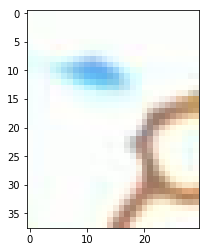

possible: [[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
scores: [[0.39137036 0.35084978 0.43317109 0.35996634 0.32592461]
 [0.36647126 0.37512842 0.21797448 0.38057801 0.95553893]
 [0.35133514 0.33200192 0.3967047  0.41774747 0.36669064]
 [0.38163379 0.32586282 0.48349586 0.45936084 0.30181432]
 [0.27295566 0.32783064 0.41211614 0.46671093 0.34858206]]
DRAG TO:  4 1
ply.tryOneDrag 235 173 474 134 (491, 739) True False
received: 
(0.0, 0.0, 0)
received:     M         1         6 6         1 7 7
received:     M         4         0         0
received: 
(66.0, 177.0, 1)
received:     M         1         6 6         1 1 1
received:     M         3         0         0
received: 
(66.0, 111.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.669733047485352


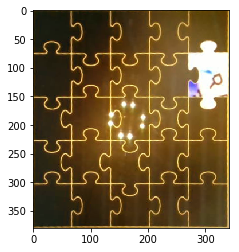

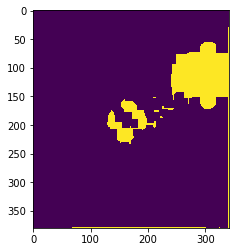

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.97368421e-01
  2.95065789e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.82401316e+01
  2.54062500e+02]
 [0.00000000e+00 6.85855263e+00 1.02927632e+02 1.06085526e+01
  2.50164474e+01]
 [0.00000000e+00 0.00000000e+00 2.66447368e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 3.35526316e+00 3.35526316e+00 3.35526316e+00
  1.52960526e+00]]
TRIED: 1
DRAG TO:  2 3
ply.tryOneDrag 509 173 337 286 (491, 739) True False
received: 
(0.0, 0.0, 0)
received:     M         1         6 6         8 6
received:     M         4         0         0
received: 
(66.0, 86.0, 1)
received:     M         1         1 1 5         1 5 7
received:     M         3         0         0
received: 
(115.0, 157.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.621251583099365


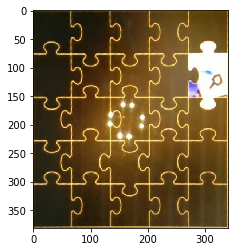

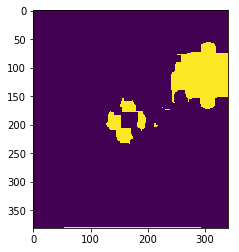

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 4.93421053e-02
  2.53125000e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.71875000e+01
  2.55000000e+02]
 [0.00000000e+00 8.78289474e+00 9.44901316e+01 5.62500000e+00
  2.66447368e+01]
 [0.00000000e+00 0.00000000e+00 4.34210526e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]
TRIED: 2


In [19]:
def playOneStep(ply):
    img = ply.getOneShot() # whole screen before move
    target = cutout_target(img.copy())
    
    (x0,y0), scores = old_matching(ply.sourceimg.copy(),img.copy(),mode = "match",debug = True)
    print("Template: ",x0,y0,"img shape: ", img.shape[:2])
    #应该还需要10-20的调整
    #为什么有时候会出现不停止直接走然后图像出现异常的情况
    possible = findEmpty(ply.emptyimg,target,mode = "debug")
    ey = np.argmax(scores)//5 
    ex = np.argmax(scores)%5
    while(not possible[ey][ex]):
        scores[ey][ex] = -1
        ey = np.argmax(scores)//5 
        ex = np.argmax(scores)%5
    print("###EX,EY####",ex,ey)
    moved_template = DragToCorner(ply,target.shape[:2],img.shape[:2],(x0,y0),ex,ey) # screen after the template is moved to corner
#     global tmpcount
#     cv2.imwrite("tmpMovedTemplate%d.png"%tmpcount,moved_template)
#     cv2.imwrite("tmpSourceImg%d.png"%tmpcount,img)
#     tmpcount += 1    
    template = find_template(moved_template,img,ex,ey)
    plt.imshow(template)
    plt.show()
    source = cutout_target(ply.sourceimg)
    scores = matching(source,template)
#     print("Rx,RY",rx,ry)
#     rx,ry = min(4,rx),min(4,ry)
#     rx,ry = int(rx),int(ry)
#     scores = matching(ply.sourceimg,moved_template,img,mode = "match",debug = True)
#     scores[ry][rx] = 99999999
    initial_num = possible.sum()
    print("possible:", possible)
    print("scores:",scores)
#     ex,ey = 0,0 # the point to check the correctness
    scores[ey][ex] = -1
    triedCount = 0
    while(possible.sum()>0):
        y = np.argmax(scores)//5 # x => i 
        x = np.argmax(scores)%5
        print("DRAG TO: ",x,y)
        scores[y][x]=-1
        if(not possible[y][x] ): # we don't have to move to 0,0, we just check it in the next round
            continue
        possible[y][x] = False
        
        timg = dragToGrid(ply,ex,ey,x,y,target.shape[:2],img.shape[:2],shot=True, back = False)
        timg = cutout_target(timg)
#         print("Tries To Drag:",x0,y0,x,y)
        
        triedCount += 1
        
        plt.imshow(timg)
        plt.show()
        empty = findEmpty(ply.emptyimg,timg,mode = "debug")
        print("TRIED:", triedCount )
        if(not empty[ey][ex] or empty[y][x]):
            break
        ex,ey = x,y
playOneStep(ply)

In [15]:
tmpcount = 0

In [108]:
img = ply.getOneShot()
cv2.imwrite("tmp.png",img)



received: 
600 800 3
30000
-1.9349322319030762


True

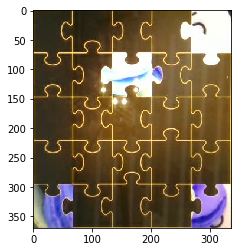

(370, 337, 3)


In [92]:
# ply.movetoImg(197,54,img.shape[:2])
# ply.movetoImg(532,427,img.shape[:2])
sor = cutout_target(img)

plt.imshow(sor)
plt.show()
print(sor.shape)